In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv
/kaggle/input/contractions/contractions.csv


a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4),surprise(5).

In [2]:
emo_la={0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

In [3]:
emo_la[1]

'joy'

In [4]:
data=pd.read_csv('../input/emotion-dataset/training.csv')
data

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


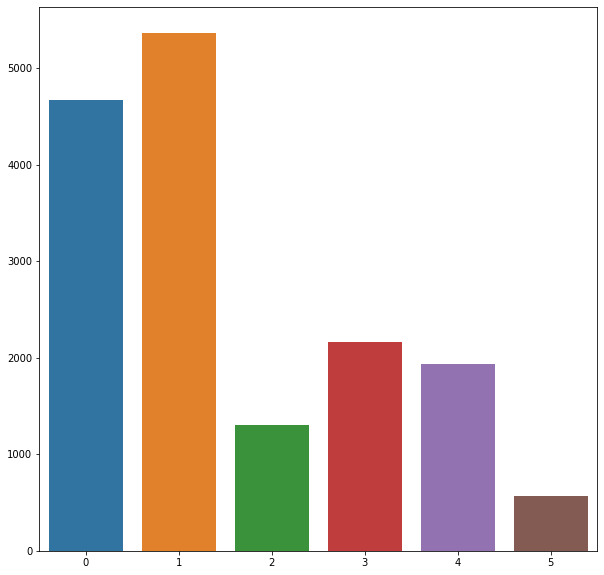

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.barplot(x=data['label'].value_counts().index,y=data['label'].value_counts().values)
palette_color = sns.color_palette('bright')
  

  
# displaying chart
plt.show()

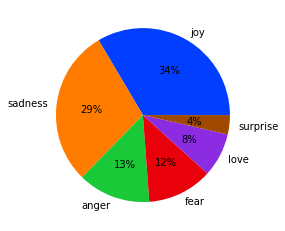

In [6]:
plt.pie(data['label'].value_counts(), labels=data['label'].apply(lambda x:emo_la[x]).value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

In [7]:
pd.options.display.max_colwidth = 1000
data[data['label']==5].loc[32]


text     i have seen heard and read over the past couple of days i am left feeling impressed by more than a few companies
label                                                                                                                   5
Name: 32, dtype: object

In [8]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

import re
data_cl=data.copy()
contractions=pd.read_csv('../input/contractions/contractions.csv',index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']
k=stopwords.words('english')

k=[i for i in k if i!='not']


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [9]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"
lemmatizer = WordNetLemmatizer()
def preprocess_apply(tweet):

    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    tweet = nltk.word_tokenize(tweet)
    tweet = [lemmatizer.lemmatize(sentence)  for sentence in tweet if sentence not in k]
        #if sentence not in stopwords.words('english')
    return tweet

In [10]:
def text_cleaning(x):
    sentences=[]
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    for i in range(1):
        paragraph=x
        text = re.sub(r'\[[0-9]*\]',' ',paragraph)
        text =' '.join(word for word in text.split(' ') if not word.startswith('@'))
        text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
        sentenc = nltk.word_tokenize(text)
        #sentenc = sentenc.split()
        #print(sentenc)
        sentenc = [lemmatizer.lemmatize(sentence)  for sentence in sentenc if sentence not in stopwords.words('english')]
        #if sentence not in stopwords.words('english')
    return sentenc   

In [11]:
data_cl['text']=data['text'].apply(lambda x:preprocess_apply(x))

In [12]:
preprocess_apply("  not sad ")


['not', 'sad']

In [13]:
# for i in range(len(data_cl['text'])):
#     if any('servant' in z for z in X_test.loc[i]):
#         print(i,'yes')
#         break
    
# data_cl.loc[6,'text']

In [14]:
data_cl['text']=data_cl['text'].map(lambda x:' '.join(x))
data_cl.loc[6,'text']

'ive taking milligram time recommended amount ive fallen asleep lot faster also feel like funny'

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
cv=TfidfVectorizer(max_features=3000).fit(data_cl['text'])
X = cv.fit_transform(data_cl['text']).toarray()
X.shape

(16000, 3000)

In [17]:
y=data_cl['label']

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [20]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test['text']=X_test['text'].apply(lambda x:text_cleaning(x))
X_test['text']=X_test['text'].map(lambda x:' '.join(x))
X_test = cv.transform(X_test['text'])
X_test

<2000x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 15545 stored elements in Compressed Sparse Row format>

In [21]:
X_test

<2000x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 15545 stored elements in Compressed Sparse Row format>

In [22]:

y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.8765
Testing F1 score: 0.8765916732070523


In [23]:
text='happy'
text=list(str(text).split("."))
text=pd.Series(text)
print(text)
text=text.apply(lambda x:preprocess_apply(x))
print(text)
text=text.apply(lambda x:' '.join(x))
print(text)
text = cv.transform(text)
emo_la[classifier.predict(text)[0]]
[emo_la[s] for s in classifier.predict(text)]

0    happy
dtype: object
0    [happy]
dtype: object
0    happy
dtype: object


['joy']

In [24]:
import pickle
filename = 'finalized_model.pkl'
with open(filename,'wb') as f:
    pickle.dump(classifier,f)

In [25]:
import pickle
filename = 'finalized_model_tfidf.pkl'
with open(filename,'wb') as f:
    pickle.dump(cv,f)

In [26]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(data_cl.text)]
#display the tagged docs
#card_docs

In [27]:
#instantiate model
model = Doc2Vec(vector_size=24, window=2, min_count=1, workers=8, epochs = 100)
#build vocab
model.build_vocab(card_docs)
#train model
model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)


In [28]:
#generate vectors
card2vec = [model.infer_vector((data_cl.text[i].split(' '))) 
            for i in range(0,len(data_cl.text))]
#card2vec


In [29]:
#Create a list of lists
dtv= np.array(card2vec).tolist()
#set list to dataframe column
data_cl['card2vec'] = dtv
data_cl.head(2)

,text,label,card2vec
0,didnt feel humiliated,0,"[-0.6907301545143127, 0.3293410539627075, -0.13407957553863525, 0.4154246151447296, 0.45463377237319946, -0.16794486343860626, 0.17455363273620605, -0.2075994908809662, -0.5960902571678162, 0.29433995485305786, 0.14817246794700623, -0.002240437548607588, -0.25236013531684875, -0.01364750787615776, -0.48054972290992737, 0.6057925224304199, -0.5216194987297058, 0.20189762115478516, -0.2368055135011673, 0.16476386785507202, 0.4724339246749878, -0.07186953723430634, 1.3432865142822266, 0.21347837150096893]"
1,go feeling hopeless damned hopeful around someone care awake,0,"[-2.330378532409668, -0.6581130027770996, 0.5366047024726868, 2.1504430770874023, 0.6896774768829346, 1.182678461074829, -0.35320109128952026, -0.22903013229370117, 1.3991888761520386, 0.2835998237133026, 0.6544948816299438, 0.06605725735425949, 0.10888560116291046, -0.7360866665840149, -0.5467789173126221, 1.7088967561721802, -0.5841893553733826, -0.7892470955848694, 1.5171515941619873, 0.6034523248672485, 0.247245192527771, -0.2930087149143219, -1.3872815370559692, 0.6490201950073242]"


In [30]:
X=data_cl['card2vec']
y=data_cl['label']

In [31]:
X=pd.DataFrame(item for item in X)
X

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.690730,0.329341,-0.134080,0.415425,0.454634,-0.167945,0.174554,-0.207599,-0.596090,0.294340,...,-0.480550,0.605793,-0.521619,0.201898,-0.236806,0.164764,0.472434,-0.071870,1.343287,0.213478
1,-2.330379,-0.658113,0.536605,2.150443,0.689677,1.182678,-0.353201,-0.229030,1.399189,0.283600,...,-0.546779,1.708897,-0.584189,-0.789247,1.517152,0.603452,0.247245,-0.293009,-1.387282,0.649020
2,0.520063,0.239662,1.180394,0.867285,-0.540528,-2.207750,-0.979437,-0.271587,-0.211511,-2.132988,...,-0.044408,0.563339,-0.685260,-1.254488,-0.529327,0.565892,-0.600816,-0.086433,1.512429,0.425676
3,-0.738136,-0.512649,-0.711390,-0.317458,-0.977655,-0.581738,0.493948,0.336914,-0.771470,0.255439,...,-0.343707,-1.291833,-1.329201,-0.662330,-0.630717,-0.743287,1.686997,-0.110291,0.312838,-0.250152
4,-0.506658,0.196423,0.253468,0.417223,0.281877,-0.064884,-0.438714,-0.330622,0.039883,-0.449432,...,-0.379381,0.221458,-0.711619,0.547373,0.069806,0.024889,0.372581,0.090115,0.394934,0.005271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,-0.342400,0.295285,0.157408,-0.134808,-0.785437,-0.060749,-0.366170,0.226425,-1.288904,-1.436252,...,0.177401,0.314736,-0.534947,-0.649126,1.073738,0.297500,0.911574,-0.519051,0.231357,-0.506635
15996,-0.257414,-0.294248,-0.189176,0.397777,-1.343263,-0.621654,-0.058509,1.449236,1.098571,-1.237672,...,-0.532969,-0.613645,-0.225347,0.128031,1.027369,-0.188128,2.800260,0.269004,0.961868,-0.110420
15997,-1.144505,-0.659150,-0.604474,-0.064998,-0.129096,0.502783,-0.199842,0.365558,1.010224,-0.210563,...,-0.324224,1.044281,0.390260,1.742683,-0.758748,-0.216324,0.789615,0.040581,0.864824,0.405349
15998,-0.751631,0.296736,-0.774003,0.399290,-0.527281,-0.801148,-0.488235,0.149862,-0.164078,-0.573758,...,0.653547,0.402048,-0.030921,-0.939558,-0.707695,0.217393,1.083568,-0.121155,1.087536,0.498983


In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [33]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test['text']=X_test['text'].apply(lambda x:text_cleaning(x))
X_test['text']=X_test['text'].map(lambda x:' '.join(x))
card2vec = [model.infer_vector((X_test.text[i].split(' '))) 
            for i in range(0,len(X_test.text))]
#card2vec
#Create a list of lists
X_test= np.array(card2vec).tolist()
X_test=pd.DataFrame(item for item in X_test)
#set list to dataframe column
#X_test

In [34]:
y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.4435
Testing F1 score: 0.387070858115705


#### Word2vec implemented with tfidf

In [35]:
review_text = data['text'].apply(gensim.utils.simple_preprocess)

In [36]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=1,
    workers=4,
)
model.build_vocab(review_text)

model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

(1001242, 1362360)

In [37]:
review_text[6]

['ive',
 'been',
 'taking',
 'or',
 'milligrams',
 'or',
 'times',
 'recommended',
 'amount',
 'and',
 'ive',
 'fallen',
 'asleep',
 'lot',
 'faster',
 'but',
 'also',
 'feel',
 'like',
 'so',
 'funny']

In [38]:
model.wv.most_similar('love')

[('see', 0.9893202781677246),
 ('trust', 0.9871305823326111),
 ('way', 0.9835997819900513),
 ('someone', 0.9804139137268066),
 ('can', 0.9794450998306274),
 ('kick', 0.9791281223297119),
 ('important', 0.9767650961875916),
 ('sincere', 0.9766086935997009),
 ('deal', 0.9756659269332886),
 ('will', 0.9746040105819702)]

In [39]:

mod = Word2Vec(review_text, min_count=1)

words = model.wv.index_to_key



In [40]:
lemmatizer = WordNetLemmatizer()
[lemmatizer.lemmatize(word ) for word in['give','take']]

['give', 'take']

In [41]:
def sentence_to_vector(model,sentence):
    sentence=pd.Series(data=[sentence])
    sentence=sentence.apply(gensim.utils.simple_preprocess).tolist()
    sentence=[word for sen in sentence for word in sen]
    #print([model.wv.get_vector(word)  for word in sentence])
    return np.mean([model.wv.get_vector(word)  for word in sentence] ,axis=0)
    

In [42]:
sentence=[[1,2],[2,0],[3,8],[4,6]]
np.mean([word  for word in sentence] ,axis=0)

array([2.5, 4. ])

In [43]:
model.wv.get_vector('milligrams')

array([-0.00753113,  0.00119593,  0.0068093 , -0.00390576,  0.01042199,
       -0.00567685,  0.00271028,  0.01966865, -0.00105973, -0.00383076,
       -0.00283908, -0.00971972,  0.00429838, -0.01243212, -0.00886823,
       -0.01454409,  0.0016936 , -0.00731454,  0.00342193, -0.01609846,
        0.00237075,  0.00192783,  0.0071359 , -0.00618019, -0.00393996,
        0.00917256,  0.00806945, -0.00601391,  0.00103321,  0.00606816,
        0.00404662,  0.00211792,  0.00627145, -0.01022667, -0.00492162,
        0.0054958 , -0.00248308, -0.0080095 ,  0.00055807, -0.01097313,
        0.00795571, -0.00963457,  0.01036323, -0.00805018, -0.00713864,
        0.00067541, -0.00024432,  0.00196889, -0.00681804,  0.00342068,
        0.01511919,  0.00500399, -0.00233244,  0.00815354, -0.01792486,
       -0.00374777,  0.00982139,  0.00687406, -0.00957618,  0.00615614,
       -0.01090954, -0.00811507, -0.00432805, -0.0056119 , -0.01062856,
        0.00680897, -0.00397188,  0.00442292, -0.02083229, -0.00

In [44]:
# sentence=pd.Series(data=["i like cookies"])
# vec=sentence_to_vector(model,sentence)
# vec

In [45]:
data_wv=data.copy()
data_wv['avg_vec']=data_wv['text'].apply(lambda x:sentence_to_vector(model,x))


In [46]:
data_wv['label']

0        0
1        0
2        3
3        2
4        3
        ..
15995    0
15996    0
15997    1
15998    3
15999    0
Name: label, Length: 16000, dtype: int64

In [47]:
X=data_wv['avg_vec']
y=data_wv['label']

In [48]:
X

0        [-0.48630798, 0.21910977, -0.22812326, 0.17314745, 0.26199728, -1.1515235, 0.7476695, 1.4771295, -0.5526883, -0.3250096, -0.015832974, -0.98798925, -0.24744533, 0.42208, -0.035409477, -0.4508495, 0.33316934, -0.3306909, -0.12220719, -1.0841125, 0.5408724, 0.49886084, 0.6442618, -0.0174935, -0.031155542, -0.19816792, -0.40465045, -0.03122955, -0.4814837, -0.4148896, 0.7666363, 0.09302827, 0.45717022, -0.44394603, -0.4371657, 0.44208583, 0.53838116, -0.34836543, -0.016219543, -0.80225176, -0.053418178, -0.11506363, -0.22092457, 0.043563295, 0.33603752, -0.013722122, -0.38574922, -0.014747317, 0.60559654, 0.53271174, 0.24595173, 0.10969442, 0.0021367471, -0.18206452, 0.118540145, 0.010043182, 0.39718768, -0.25545254, -0.32835585, 0.44345984, 0.23224966, 0.002979651, 0.20474528, -0.0062864535, -0.71497655, 0.5412827, 0.24362914, 0.90707856, -0.99104863, 0.7776703, -0.27310017, 0.23115973, 0.80750465, -0.11494819, 0.6535348, -0.035203844, 0.1900326, -0.06395602, -0.5032592, 0.01327

In [49]:
X=pd.DataFrame(item for item in X)
X

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.486308,0.219110,-0.228123,0.173147,0.261997,-1.151523,0.747670,1.477129,-0.552688,-0.325010,...,0.799637,0.449649,0.405128,0.112862,1.431624,0.612421,-0.053955,-0.352584,0.246445,0.380044
1,-0.391584,0.257450,-0.064490,0.113982,0.407686,-0.969428,0.684329,1.540177,-0.480254,-0.286578,...,0.846091,0.280938,0.505993,-0.024976,1.435132,0.579495,0.267001,-0.203620,0.198355,0.239889
2,-0.337331,0.137343,-0.140215,0.089673,0.293894,-0.813390,0.525595,1.181849,-0.418267,-0.198963,...,0.580888,0.321140,0.297546,0.032790,1.074596,0.490662,0.143570,-0.270207,0.086250,0.270866
3,-0.381767,0.271566,-0.148459,0.137869,0.451458,-1.061157,0.694246,1.629765,-0.492653,-0.364525,...,0.848089,0.320445,0.562382,0.102610,1.425847,0.562244,0.236209,-0.213073,0.171968,0.312961
4,-0.329687,0.217293,-0.061802,-0.057830,0.147602,-0.929938,0.560351,1.345035,-0.784426,-0.439686,...,0.744084,0.603039,0.067171,0.030678,1.053255,0.554806,-0.086623,-0.928096,0.258335,0.351046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,-0.291085,0.227012,-0.063851,-0.038887,0.442206,-0.848203,0.706675,1.431567,-0.462839,-0.170366,...,0.687409,0.214555,0.614739,-0.007121,1.399390,0.424677,0.247844,-0.374669,0.295424,0.162075
15996,-0.311432,0.229156,-0.038886,0.113088,0.331692,-0.861478,0.491520,1.242327,-0.443774,-0.323971,...,0.635792,0.267810,0.374582,0.028973,0.987412,0.444557,0.122935,-0.302986,0.104699,0.283196
15997,-0.471432,0.279497,-0.084239,0.218398,0.313554,-0.991192,0.667462,1.467602,-0.464197,-0.307075,...,0.742918,0.304390,0.425799,0.026088,1.353148,0.574622,0.090661,-0.366795,0.249970,0.377242
15998,-0.328671,0.265154,-0.124120,0.075893,0.376991,-1.090279,0.656680,1.544083,-0.544643,-0.328216,...,0.820544,0.341854,0.531906,0.044658,1.286869,0.488313,0.176767,-0.331299,0.153301,0.318734


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=42)

In [51]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test=X_test['text'].apply(gensim.utils.simple_preprocess)
documents=[]
for x in X_test:
    document = [word for word in x if word in model.wv.index_to_key]
    documents.append(document)
len(documents)

2000

In [52]:
counter = 0
for i in range (0,len(documents)):
    if documents[i] == []:
        counter += 1
print(counter)

0


In [53]:
documents=[' '.join(i) for i in documents]
documents=pd.Series(data=documents)

In [54]:
documents

0                                                                                                                           im feeling quite sad and sorry for myself but ill snap out of it soon
1                                                                                                                                feel like am still looking at blank canvas blank pieces of paper
2                                                                                                                                                                              feel like faithful
3                                                                                                                                                                 am just feeling cranky and blue
4                                                                                                                                                     can have for treat or if am feeling festive
                              

In [55]:
X_test=documents.apply(lambda x:sentence_to_vector(model,x))
X_test=pd.DataFrame(item for item in X_test)


In [56]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.378675,0.278221,-0.035383,0.062942,0.343190,-0.979123,0.609473,1.526425,-0.573149,-0.339812,...,0.789358,0.361212,0.414027,-0.016464,1.290950,0.543654,0.189564,-0.441774,0.207100,0.296348
1,-0.336314,0.248537,-0.014185,0.099632,0.338417,-0.821691,0.460539,1.264634,-0.460728,-0.322052,...,0.678921,0.319609,0.421199,0.017774,1.101234,0.474653,0.170714,-0.364569,0.141558,0.319610
2,-0.473594,0.233770,-0.198576,0.085931,0.315825,-1.285671,0.788428,1.611873,-0.621977,-0.438458,...,0.921546,0.446135,0.485798,0.112867,1.608201,0.661879,-0.010650,-0.254598,0.226181,0.268113
3,-0.347664,0.235042,-0.023275,0.016278,0.241170,-0.964649,0.592445,1.470401,-0.660358,-0.382737,...,0.778110,0.441806,0.255891,-0.017993,1.172644,0.565401,0.090044,-0.637288,0.215591,0.304137
4,-0.466940,0.291131,-0.072703,0.041212,0.424903,-1.131771,0.734799,1.606942,-0.612437,-0.359122,...,0.926690,0.469775,0.532073,0.000278,1.574524,0.624532,0.229672,-0.239826,0.163114,0.209363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-0.359107,0.293745,-0.053198,0.136726,0.402613,-0.869984,0.519810,1.372793,-0.402585,-0.311904,...,0.678492,0.246475,0.543236,0.053936,1.209673,0.468925,0.169067,-0.303890,0.157168,0.322682
1996,-0.402960,0.330959,-0.018096,0.236033,0.400845,-0.735179,0.519109,1.193744,-0.253581,-0.257388,...,0.558381,0.137599,0.456042,0.006615,1.130699,0.406514,0.235922,-0.101245,0.149098,0.306883
1997,-0.429883,0.264008,-0.131206,0.175064,0.434708,-0.955389,0.728992,1.522837,-0.396136,-0.271497,...,0.713310,0.221968,0.548558,0.063899,1.445132,0.527112,0.255640,-0.144263,0.227086,0.275860
1998,-0.495823,0.285021,-0.201532,0.203451,0.532686,-1.204964,0.804856,1.632865,-0.424039,-0.310546,...,0.860558,0.284104,0.503761,0.064216,1.566406,0.640111,0.259832,0.176842,-0.001190,0.195558


In [57]:
y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.319
Testing F1 score: 0.26810661802268365


In [58]:
sent=['i am sad ']
sent=pd.DataFrame(data=sent,columns=['data'])
sent=sent['data'].apply(gensim.utils.simple_preprocess)
print(sent)
documents=[]
for x in sent:
    document = [word for word in x if word in model.wv.index_to_key]
    documents.append(document)
print(documents)
counter = 0
for i in range (0,len(documents)):
    if documents[i] == []:
        counter += 1
documents=[' '.join(i) for i in documents]
documents=pd.Series(data=documents)
sent=documents.apply(lambda x:sentence_to_vector(model,x))
sent=pd.DataFrame(item for item in sent)
sent

0    [am, sad]
Name: data, dtype: object
[['am', 'sad']]


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.212139,0.265411,-0.158418,0.043399,0.498835,-1.125694,0.433488,1.419979,-0.676952,-0.468987,...,0.76359,0.527688,0.378667,0.11273,0.941798,0.4444,0.190933,-0.409815,-0.192134,0.421695


In [59]:
emo_la[int(classifier.predict(sent))]

'anger'

#### new_word2vec

In [60]:
import re
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', raw_text)
    return cleaned_text

In [61]:
df=data.copy()
df.drop_duplicates(inplace=True)

In [62]:
df['text'] = df['text'].apply(lambda x:x.lower())

In [63]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [64]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
story = []
for doc in df['text']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))
    


In [65]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=1
)
model.build_vocab(story)
model.train(story, total_examples=model.corpus_count, epochs=model.epochs)

(640263, 746965)

In [66]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [67]:
df.loc[8823]

text     feel kind petty blogging
label                           3
Name: 8823, dtype: object

In [68]:
from tqdm import tqdm
X = []
for doc in tqdm(df['text'].values):
    X.append(document_vector(doc))

100%|██████████| 15999/15999 [00:06<00:00, 2627.81it/s]


In [69]:
X = np.array(X)
y=df['label']

In [70]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)


RandomForestClassifier()

In [71]:
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

0.33875

Bert Model


In [21]:
pip install transformers 

Note: you may need to restart the kernel to use updated packages.


In [14]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [45]:
from sklearn.model_selection import train_test_split
X=data_cl['text']
y=data_cl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [46]:
train=pd.DataFrame()
test=pd.DataFrame()
train['text']=X_train
train['sentiment']=y_train
test['text']=X_test
test['sentiment']=y_test

In [18]:
def convert_data_to_examples(train, test, text, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'text',  'sentiment')

In [24]:
from tqdm import tqdm
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

In [25]:
import tensorflow as tf
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/9600 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 9600/9600 [00:00<00:00, 10900.04it/s]


In [26]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 3200/3200 [00:00<00:00, 11191.03it/s]


In [27]:
num_labels = 6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


model.fit(train_data, epochs=2,steps_per_epoch=115, validation_data=validation_data)

Epoch 1/2
115/115 [==============================] - 2422s 21s/step - loss: 1.3716 - accuracy: 0.4655 - val_loss: 0.8368 - val_accuracy: 0.7131
Epoch 2/2
115/115 [==============================] - 2402s 21s/step - loss: 0.6028 - accuracy: 0.7970 - val_loss: 0.5058 - val_accuracy: 0.8281


In [28]:
train_data

<RepeatDataset shapes: ({input_ids: (None, None), attention_mask: (None, None), token_type_ids: (None, None)}, (None,)), types: ({input_ids: tf.int32, attention_mask: tf.int32, token_type_ids: tf.int32}, tf.int64)>

In [59]:
pred_sentences = [' dont know who lnocked the door ' , 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs = model(tf_batch)                                  
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
# labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", emo_la[label[i]])

 dont know who lnocked the door  :  fear
Wow, blew my mind, what a movie by Marvel, animation and story is amazing :  surprise


In [30]:
tf_predictions

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.38976142, 0.07313882, 0.0518993 , 0.13277097, 0.32578304,
        0.02664651],
       [0.01684946, 0.12734203, 0.02270525, 0.01233886, 0.06884786,
        0.7519165 ]], dtype=float32)>

In [47]:
X_val
test_set=[i for i in X_val]

In [34]:
def predict_bert(data):
    tf_batch = tokenizer(data, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
    tf_outputs = model(tf_batch)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
    # labels = ['Negative','Positive']
    label = tf.argmax(tf_predictions, axis=1)
    y_pred = label.numpy()
    return y_pred

In [48]:

from sklearn.metrics import confusion_matrix
y_pred=predict_bert(test_set)
confusion_matrix(y_val, y_pred)

array([[887,  11,  12,  10,  36,   3],
       [  9, 941,  75,   2,   1,  16],
       [  8,  20, 217,   1,   2,   1],
       [ 71,   4,   2, 311,  47,   5],
       [ 10,   3,   1,   2, 376,  14],
       [  1,   0,   1,   1,  17,  82]])

In [49]:
confusion_matrix(y_val, y_pred)

array([[887,  11,  12,  10,  36,   3],
       [  9, 941,  75,   2,   1,  16],
       [  8,  20, 217,   1,   2,   1],
       [ 71,   4,   2, 311,  47,   5],
       [ 10,   3,   1,   2, 376,  14],
       [  1,   0,   1,   1,  17,  82]])

In [50]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))
print(emo_la)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       959
           1       0.96      0.90      0.93      1044
           2       0.70      0.87      0.78       249
           3       0.95      0.71      0.81       440
           4       0.78      0.93      0.85       406
           5       0.68      0.80      0.74       102

    accuracy                           0.88      3200
   macro avg       0.83      0.86      0.84      3200
weighted avg       0.89      0.88      0.88      3200

0.879375
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [55]:
model.save('bert_model')


In [ ]:
model2 = tf.keras.models.clone_model(model)
# Verify that the architecture is the same
assert model1.summary() == model2.summary()

# Verify that the weights are the same
assert model1.get_weights() == model2.get_weights()

In [56]:
!zip -r file.zip /kaggle/working/bert_model

  adding: kaggle/working/bert_model/ (stored 0%)
  adding: kaggle/working/bert_model/saved_model.pb (deflated 92%)
  adding: kaggle/working/bert_model/variables/ (stored 0%)
  adding: kaggle/working/bert_model/variables/variables.index (deflated 80%)
  adding: kaggle/working/bert_model/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: kaggle/working/bert_model/keras_metadata.pb (deflated 95%)
  adding: kaggle/working/bert_model/assets/ (stored 0%)


Simple bert

In [1]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from transformers import InputExample, InputFeatures

# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6)
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [15]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [16]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=6)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [17]:
from sklearn.model_selection import train_test_split
X=data_cl['text']
y=data_cl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [18]:
train=pd.DataFrame()
test=pd.DataFrame()
train['text']=X_train
train['sentiment']=y_train
test['text']=X_test
test['sentiment']=y_test

In [19]:
from transformers import InputExample, InputFeatures

In [20]:
def convert_data_to_examples(train, test, text, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'text',  'sentiment')

In [21]:
from tqdm import tqdm
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
#             return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask,  label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
#                     "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
#                 "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

In [22]:
import tensorflow as tf
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/9600 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 9600/9600 [00:05<00:00, 1851.07it/s]


In [23]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 3200/3200 [00:01<00:00, 1871.78it/s]


In [24]:
pip install tensorflow-model-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 9.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import tensorflow_model_optimization 
from tensorflow_model_optimization.sparsity import keras as sparsity
# Define the pruning schedule
pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0.50,
                                             final_sparsity=0.90,
                                             begin_step=2000,
                                             end_step=4000)

# Create a pruning callback that will apply pruning to the model
pruning_callbacks = [sparsity.UpdatePruningStep()]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


model.fit(train_data, epochs=2,steps_per_epoch=115, validation_data=validation_data,callbacks=pruning_callbacks)

Epoch 1/2
115/115 [==============================] - 1746s 15s/step - loss: 1.1352 - accuracy: 0.5962 - val_loss: 0.6264 - val_accuracy: 0.7875
Epoch 2/2
 45/115 [==========>...................] - ETA: 13:03 - loss: 0.5050 - accuracy: 0.8417

In [ ]:
pred_sentences = [' interview tomorrow,dont know if iam prepared ' , 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs = model(tf_batch)                                  
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
# labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", emo_la[label[i]])

In [ ]:
def predict_bert(data):
    tf_batch = tokenizer(data, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
    tf_outputs = model(tf_batch)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
    # labels = ['Negative','Positive']
    label = tf.argmax(tf_predictions, axis=1)
    y_pred = label.numpy()
    return y_pred

In [ ]:
X_val
test_set=[i for i in X_val]

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=predict_bert(test_set)
confusion_matrix(y_val, y_pred)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))
print(emo_la)

In [ ]:
model.save('bert_model')
!zip -r file.zip /kaggle/working/bert_model

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')